# Salary Prediction Model Comparison

This notebook compares different training approaches for the Vietnam Software Engineer Salary Prediction model:
1. Standard Training (baseline)
2. Feature Engineering
3. Hyperparameter Tuning
4. Combined Feature Engineering + Hyperparameter Tuning

We'll evaluate each approach using various metrics and visualize the results.

In [82]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import our model
# import importlib
# import salary_model # Tên file .py của bạn (không có đuôi .py)

# # Lệnh này ép Python đọc lại file code mới nhất từ ổ cứng
# importlib.reload(salary_model)

from salary_model import SalaryPredictionModel

# Set up plotting
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

In [83]:
# 1. Đọc file dữ liệu của bạn
# Hãy đảm bảo file csv nằm cùng thư mục với file code này
input_filename = '../data/processed_data/processed_salary_data_standardized.csv'
df = pd.read_csv(input_filename)

# 2. Chuyển đổi cột Salary sang dạng số (loại bỏ dấu phẩy nếu có)
df['Salary'] = df['Salary'].astype(str).str.replace(',', '', regex=False)
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

# 3. Lọc Logic (Logic Filtering)
# Giữ lại những người từ 18 tuổi trở lên
df = df[df['Age'] >= 18]

# Giữ lại những người có số năm kinh nghiệm hợp lý
# (Ví dụ: Tuổi 22 thì không thể có 10 năm kinh nghiệm được. Giả sử bắt đầu đi làm từ 16 tuổi)
df['YearsExperience'] = df['YearsExperience'].fillna(0) # Xử lý tạm NaN nếu có
df = df[df['YearsExperience'] <= (df['Age'] - 16)]

# 4. Loại bỏ Outliers bằng phương pháp IQR (Interquartile Range)
# Chỉ giữ lại dải lương phổ biến, loại bỏ các mức lương quá cao đột biến gây nhiễu
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc dữ liệu
df_refined = df[(df['Salary'] >= lower_bound) & (df['Salary'] <= upper_bound)]

# --- BƯỚC XỬ LÝ MẠNH TAY ĐỂ TĂNG R2 ---

# 1. Loại bỏ "Dữ liệu rác" (Kinh nghiệm cao nhưng lương quá thấp)
# Quy luật: Nếu > 3 năm kinh nghiệm thì lương phải > 10 triệu
mask_spam = (df['YearsExperience'] > 3) & (df['Salary'] < 10_000_000)
print(f"Loại bỏ {mask_spam.sum()} dòng dữ liệu rác (Exp cao lương thấp)")
df = df[~mask_spam]

# 2. Loại bỏ "Nghịch lý thâm niên" (Kinh nghiệm > 15 năm nhưng lương < 30 triệu)
# Những ca này làm model bị nhiễu nặng
mask_old_low_pay = (df['YearsExperience'] > 15) & (df['Salary'] < 30_000_000)
print(f"Loại bỏ {mask_old_low_pay.sum()} dòng 'Lão làng lương thấp'")
df = df[~mask_old_low_pay]

# 3. (Tùy chọn) Cắt trần kinh nghiệm (Capping Experience)
# Trong IT, khác biệt giữa 15 năm và 25 năm kinh nghiệm không ảnh hưởng nhiều đến lương bằng 2 năm vs 5 năm.
# Hãy gộp tất cả những người trên 15 năm về mốc 15 năm.
df['YearsExperience'] = df['YearsExperience'].apply(lambda x: 15 if x > 15 else x)

# 5. Xử lý các giá trị thiếu còn lại (nếu cần)
if 'OrgSize' in df_refined.columns:
    df_refined['OrgSize'] = df_refined['OrgSize'].fillna(df_refined['OrgSize'].mode()[0])
if 'LanguageHaveWorkedWith' in df_refined.columns:
    df_refined['LanguageHaveWorkedWith'] = df_refined['LanguageHaveWorkedWith'].fillna("None")

# 6. Xuất ra file mới
output_filename = 'refined_salary_data.csv'
df_refined.to_csv(output_filename, index=False)

print(f"Đã xử lý xong!")
print(f"Số lượng dòng ban đầu: {len(pd.read_csv(input_filename))}")
print(f"Số lượng dòng sau khi làm sạch: {len(df_refined)}")
print(f"File mới đã được lưu tên là: {output_filename}")
print(f"Dải lương mới: {df_refined['Salary'].min():,.0f} - {df_refined['Salary'].max():,.0f} VND")

Loại bỏ 20 dòng dữ liệu rác (Exp cao lương thấp)
Loại bỏ 4 dòng 'Lão làng lương thấp'
Đã xử lý xong!
Số lượng dòng ban đầu: 716
Số lượng dòng sau khi làm sạch: 559
File mới đã được lưu tên là: refined_salary_data.csv
Dải lương mới: 1,166,667 - 90,083,333 VND


## 1. Load and Prepare Data

In [ ]:
# Load the dataset
# Replace with your actual data loading code
df = pd.read_csv('../data/processed_data/refined_salary_data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

In [65]:
# Basic data cleaning
# Convert salary to numeric if needed
if 'Salary' in df.columns:
    df['Salary'] = df['Salary'].astype(str).str.replace(',', '').str.replace('"', '')
    df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
    
# Filter out rows with invalid salary values
df = df[df['Salary'] > 0]

# Fill missing values in YearsExperience
if 'YearsExperience' in df.columns:
    df['YearsExperience'] = df['YearsExperience'].fillna(df['YearsExperience'].median())

# # Select only the columns we need
# if set(['YearsExperience', 'Education', 'JobRole', 'LanguageHaveWorkedWith', 'Age', 'Gender', 'Salary']).issubset(df.columns):
#     df_clean = df[['YearsExperience', 'Education', 'JobRole', 'LanguageHaveWorkedWith', 'Age', 'Gender', 'Salary']]
# else:
df_clean = df

print(f"Cleaned dataset shape: {df_clean.shape}")
df_clean.describe()

Cleaned dataset shape: (559, 11)


,YearsExperience,Salary,Age
count,559.000000,5.590000e+02,559.000000
mean,6.577818,2.884594e+07,28.091234
std,3.936404,1.906929e+07,5.242224
min,0.000000,1.166667e+06,18.000000
25%,4.000000,1.500000e+07,24.000000
50%,6.000000,2.300000e+07,28.000000
75%,8.000000,3.680000e+07,31.000000
max,30.000000,9.008333e+07,57.000000


In [66]:
df_clean.head()

,YearsExperience,Education,JobRole,OrgSize,Location,Salary,CompFreq,Currency,LanguageHaveWorkedWith,Age,Gender
0,0.0,High School,Front-end Developer,100 to 499 employees,Vietnam,18400000,Monthly,VND,CoffeeScript; JavaScript; Rust,22,Male
1,7.0,Bachelor,Front-end Developer,"1,000 to 4,999 employees",Vietnam,23000000,Monthly,VND,C#,29,Male
2,2.0,Bachelor,Mobile Developer,10 to 19 employees,Vietnam,27600000,Monthly,VND,C++; Objective-C; Swift,24,Other
3,10.0,Bachelor,DevOps,10 to 19 employees,Vietnam,76666667,Monthly,VND,NaN,32,Other
4,12.0,Bachelor,Data Scientist,20 to 99 employees,Vietnam,34500000,Monthly,VND,Clojure; Java; JavaScript; Python; Scala; SQL,34,Male


In [67]:
# Split data into train and test sets
# We'll use the same test set for all models to ensure fair comparison
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (447, 11)
Test set shape: (112, 11)


In [68]:
test_df.head()

,YearsExperience,Education,JobRole,OrgSize,Location,Salary,CompFreq,Currency,LanguageHaveWorkedWith,Age,Gender
158,15.0,Bachelor,Back-end Developer,10 to 19 employees,Viet Nam,50000000,Monthly,VND,C;C#;C++;HTML/CSS;Java;JavaScript;PHP;TypeScri...,34,Male
451,6.0,Bachelor,Back-end Developer,20 to 99 employees,Viet Nam,20000000,Monthly,VND,NOT PROVIDED,31,Other
55,2.0,Master,Back-end Developer,100 to 499 employees,Viet Nam,10000000,Monthly,VND,Java;HTML;CSS,24,Other
247,12.0,Bachelor,Embedded Engineer,"1,000 to 4,999 employees",Viet Nam,52500000,Monthly,VND,NOT PROVIDED,32,Male
70,9.0,Bachelor,Back-end Developer,100 to 499 employees,Viet Nam,20000000,Monthly,VND,C#;JavaScript;PHP;Python;HTML;CSS,28,Male


## 2. Define Evaluation Functions

In [69]:
def evaluate_model(model, test_data):
    """
    Evaluate a trained model on test data
    
    Args:
        model: Trained SalaryPredictionModel instance
        test_data: DataFrame with test data
        
    Returns:
        dict: Dictionary with evaluation metrics
    """
    # Make predictions
    if hasattr(model, 'uses_engineered_features') and model.uses_engineered_features:
        # For models with engineered features, predict one by one
        predictions = []
        for _, row in test_data.iterrows():
            features = {
                'experience': row['YearsExperience'],
                'education': row['Education'],
                'job_role': row['JobRole'],
                'age': row['Age'],
                'gender': row['Gender']
            }
            predictions.append(model.predict_salary(features))
        
        y_pred = np.array(predictions)
        y_true = test_data['Salary']
    else:
        # For standard models, use predict_batch
        test_with_predictions = model.predict_batch(test_data)
        y_true = test_data['Salary']
        y_pred = test_with_predictions['PredictedSalary']
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    med_ae = np.median(np.abs(y_true - y_pred))
    med_ape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
        'med_ae': med_ae,
        'med_ape': med_ape,
        'predictions': y_pred,
        'actuals': y_true
    }

def plot_actual_vs_predicted(y_true, y_pred, title):
    """
    Plot actual vs predicted values
    
    Args:
        y_true: Array of actual values
        y_pred: Array of predicted values
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(title)
    plt.xlabel('Actual Salary')
    plt.ylabel('Predicted Salary')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    """
    Plot residuals
    
    Args:
        y_true: Array of actual values
        y_pred: Array of predicted values
        title: Plot title
    """
    residuals = y_true - y_pred
    
    plt.figure(figsize=(12, 5))
    
    # Residuals vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{title} - Residuals vs Predicted")
    plt.xlabel('Predicted Salary')
    plt.ylabel('Residuals')
    
    # Residual distribution
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f"{title} - Residual Distribution")
    plt.xlabel('Residual')
    
    plt.tight_layout()
    plt.show()

## 3. Approach 1: Standard Training (Baseline)

Standard Training Metrics:
mse: 223516834655619.66
rmse: 14950479.412233565
r2: 0.30416997577203475
mae: 11097160.917993387
mape: 53.60881928391271


<Figure size 1000x600 with 0 Axes>

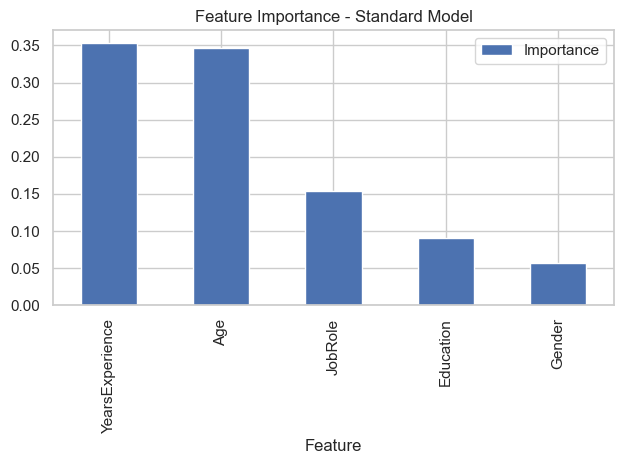

In [70]:
# Define standard model parameters
standard_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'random_state': 42
}

# Create and train standard model
standard_model = SalaryPredictionModel()
standard_metrics = standard_model.train_model(train_df, standard_params)

# Print training metrics
print("Standard Training Metrics:")
for key, value in standard_metrics.items():
    if key != 'feature_importance':
        print(f"{key}: {value}")

# Display feature importance
plt.figure(figsize=(10, 6))
standard_metrics['feature_importance'].plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance - Standard Model')
plt.tight_layout()
plt.show()

Standard Model Test Evaluation:
mse: 298594797738069.94
rmse: 17279895.767569605
r2: 0.25570480259034734
mae: 13233840.392857144
mape: 68.70195506922238
med_ae: 10856499.5
med_ape: 42.47026011764706


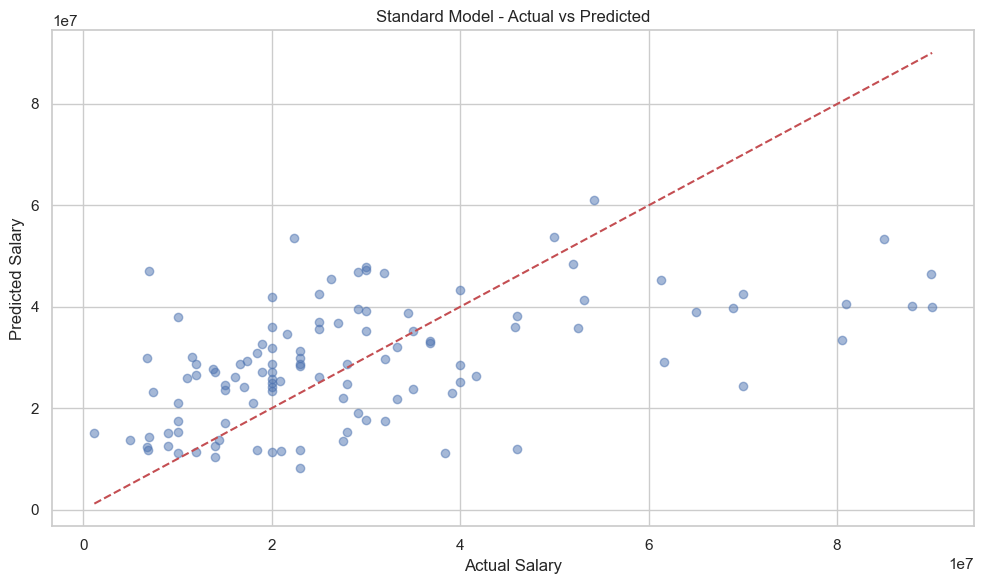

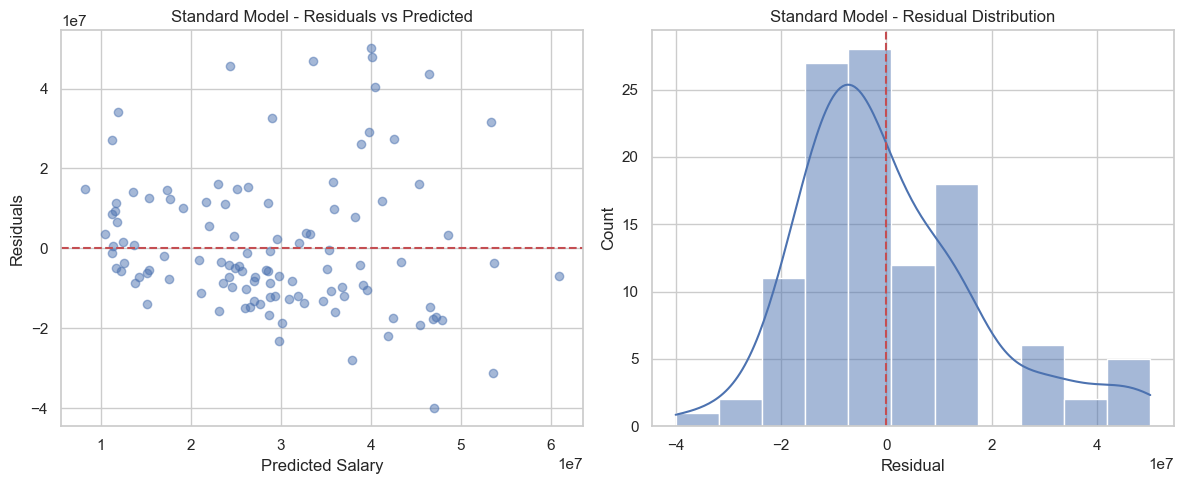

In [71]:
# Evaluate standard model on test data
standard_eval = evaluate_model(standard_model, test_df)

print("Standard Model Test Evaluation:")
for key, value in standard_eval.items():
    if key not in ['predictions', 'actuals']:
        print(f"{key}: {value}")

# Plot actual vs predicted
plot_actual_vs_predicted(standard_eval['actuals'], standard_eval['predictions'], 
                        'Standard Model - Actual vs Predicted')

# Plot residuals
plot_residuals(standard_eval['actuals'], standard_eval['predictions'], 
              'Standard Model')

## 4. Approach 2: Feature Engineering

Starting model.train_model_with_engineered_features
DataFrame shape: (447, 11)
DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'OrgSize', 'Location', 'Salary', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith', 'Age', 'Gender']
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42}
Cleaning Salary column
Salary column cleaned. Sample values: 182    23000000
89     30000000
185    17000000
148    18500000
204    27000000
Name: Salary, dtype: int64
Filtering out invalid salary values
After filtering, DataFrame shape: (447, 11)
Filling missing values in YearsExperience
Engineering features
Starting engineer_features
Input DataFrame shape: (447, 11)
Input DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'OrgSize', 'Location', 'Salary', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith', 'Age', 'Gender']
Creating experience transformations
Creating experience buckets
Creating a

<Figure size 1200x800 with 0 Axes>

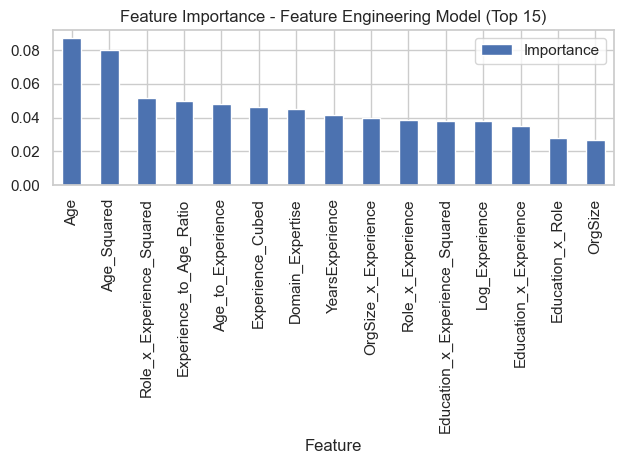

In [72]:
# Create and train model with feature engineering
fe_model = SalaryPredictionModel()
fe_metrics = fe_model.train_model_with_engineered_features(train_df, standard_params, use_log_transform=True)

# Print training metrics
print("Feature Engineering Training Metrics:")
for key, value in fe_metrics.items():
    if key != 'feature_importance':
        print(f"{key}: {value}")

# Display feature importance (top 15 features)
plt.figure(figsize=(12, 8))
fe_metrics['feature_importance'].head(15).plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance - Feature Engineering Model (Top 15)')
plt.tight_layout()
plt.show()

Starting engineer_features
Input DataFrame shape: (1, 5)
Input DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'Age', 'Gender']
Creating experience transformations
Creating experience buckets
Creating age-related features
Creating education level features
Creating job role complexity features
Creating interaction features
Creating gender features
Creating domain expertise features
Engineered DataFrame shape: (1, 23)
Engineered DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'Age', 'Gender', 'Experience_Squared', 'Experience_Cubed', 'Log_Experience', 'Experience_Bucket', 'Age_Squared', 'Age_to_Experience', 'Experience_to_Age_Ratio', 'Career_Stage', 'Education_Level', 'Role_Complexity', 'Education_x_Experience', 'Education_x_Experience_Squared', 'Role_x_Experience', 'Role_x_Experience_Squared', 'Education_x_Role', 'Gender_Numeric', 'Domain_Expertise', 'Is_Senior']
Starting engineer_features
Input DataFrame shape: (1, 5)
Input DataFrame columns: ['YearsExperi

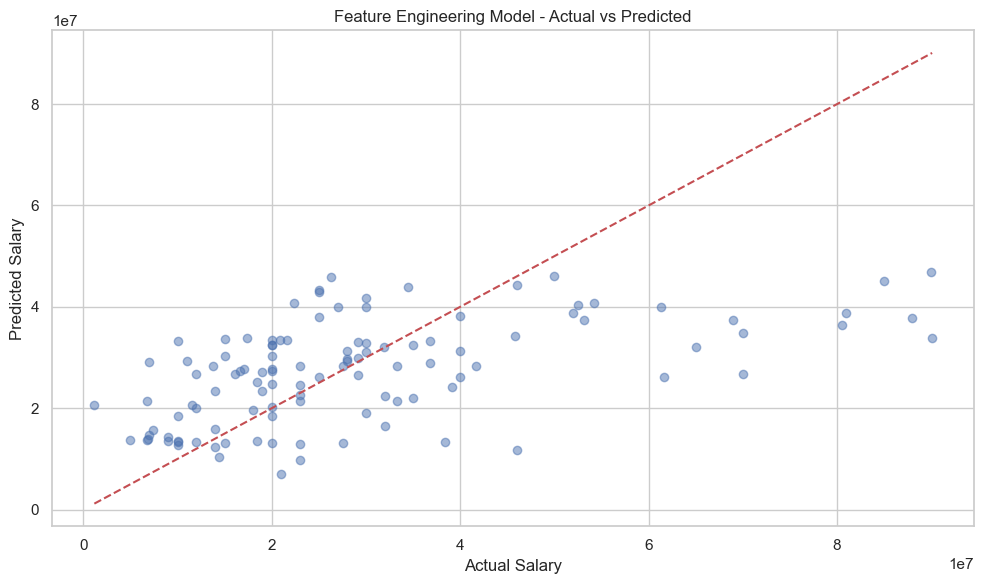

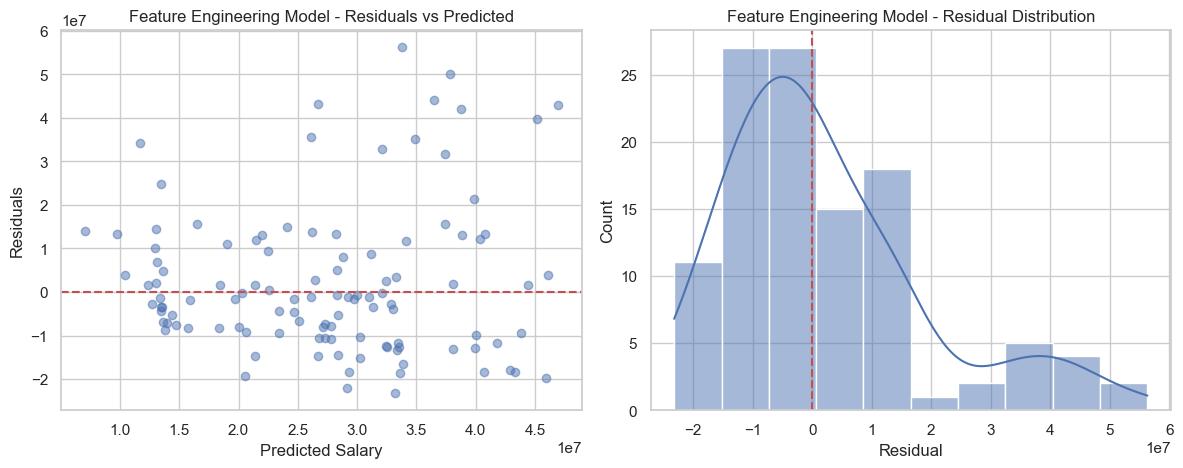

In [73]:
# Evaluate feature engineering model on test data
fe_eval = evaluate_model(fe_model, test_df)

print("Feature Engineering Model Test Evaluation:")
for key, value in fe_eval.items():
    if key not in ['predictions', 'actuals']:
        print(f"{key}: {value}")

# Plot actual vs predicted
plot_actual_vs_predicted(fe_eval['actuals'], fe_eval['predictions'], 
                        'Feature Engineering Model - Actual vs Predicted')

# Plot residuals
plot_residuals(fe_eval['actuals'], fe_eval['predictions'], 
              'Feature Engineering Model')

## 5. Approach 3: Hyperparameter Tuning

In [74]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# Create model for hyperparameter tuning
hp_model = SalaryPredictionModel()

# Tune hyperparameters (this may take some time)
tuning_results = hp_model.tune_hyperparameters(train_df, param_grid=param_grid, cv=5)

# Print best parameters
print("Best Hyperparameters:")
for key, value in tuning_results['best_params'].items():
    print(f"{key}: {value}")

# Print training metrics
print("\nHyperparameter Tuning Metrics:")
for key, value in tuning_results.items():
    if key not in ['best_params', 'cv_results', 'model', 'feature_importance']:
        print(f"{key}: {value}")

# Display feature importance
if 'feature_importance' in tuning_results:
    plt.figure(figsize=(10, 6))
    tuning_results['feature_importance'].plot(kind='bar', x='Feature', y='Importance')
    plt.title('Feature Importance - Hyperparameter Tuned Model')
    plt.tight_layout()
    plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters:
max_depth: 10
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 2
n_estimators: 200
random_state: 42

Hyperparameter Tuning Metrics:
best_score: -259158227566185.66
mse: 193037734817315.62
rmse: 13893802.028865807
r2: 0.3990544296057248
mae: 10334976.781293595
mape: 51.922814508031564
med_ae: 7060502.986341072
med_ape: 33.29277757372488
test_predictions: [28140989.11110425 13174283.88708734 29125699.92985211 16516642.0148939
 33648025.26607253 15223255.44489253 16998062.86135682 28779405.04313892
 32680866.48129796 40644715.46390293 31210254.05999989 41859558.87943377
 48024839.67465069 16627188.729062   29204369.31753585 15072624.22548024
 35754509.63410249 14167800.20447821 15108142.6968909  15223255.44489253
 28254507.83667665 13328082.56710628 36744232.39148887 22694977.72970222
 17019027.31300607 41793543.13530912 30412241.94998499 26006709.7972464
 26675082.88184388 16750222.78874055 3702

Hyperparameter Tuned Model Test Evaluation:
mse: 287767897780851.56
rmse: 16963722.992929693
r2: 0.2826925790085464
mae: 12753255.017857144
mape: 67.92048009929775
med_ae: 9733798.5
med_ape: 44.054373188559985


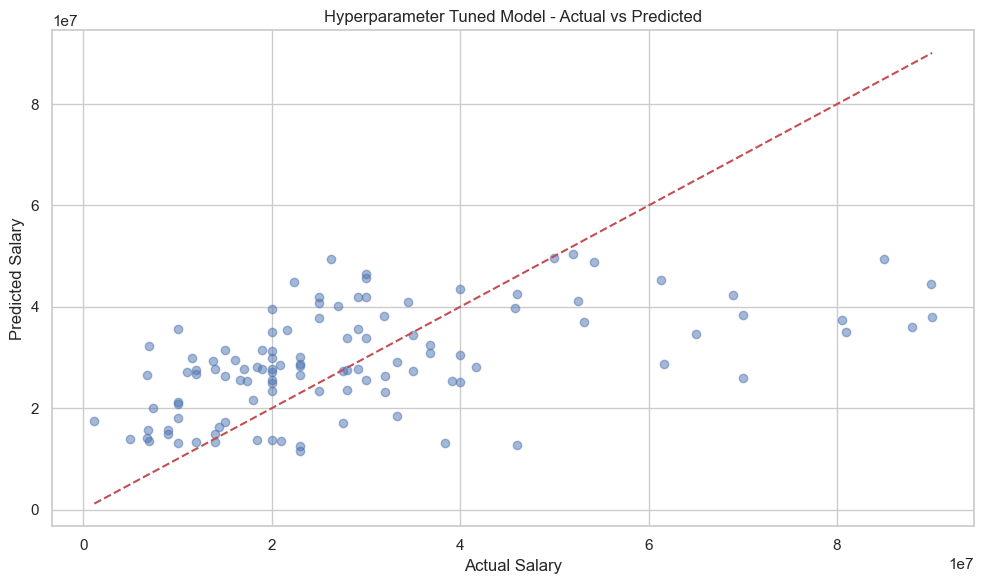

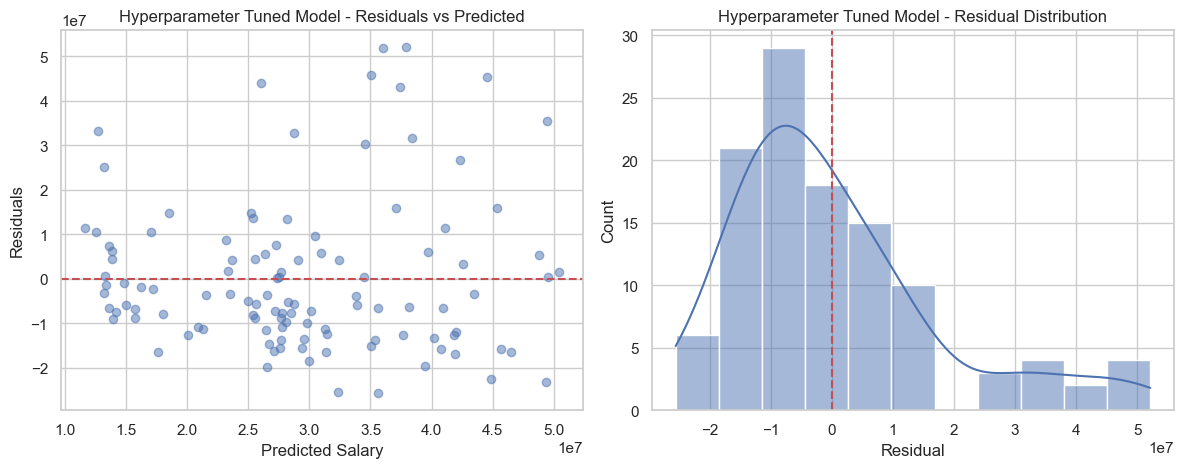

In [75]:
# Evaluate hyperparameter tuned model on test data
hp_eval = evaluate_model(hp_model, test_df)

print("Hyperparameter Tuned Model Test Evaluation:")
for key, value in hp_eval.items():
    if key not in ['predictions', 'actuals']:
        print(f"{key}: {value}")

# Plot actual vs predicted
plot_actual_vs_predicted(hp_eval['actuals'], hp_eval['predictions'], 
                        'Hyperparameter Tuned Model - Actual vs Predicted')

# Plot residuals
plot_residuals(hp_eval['actuals'], hp_eval['predictions'], 
              'Hyperparameter Tuned Model')

## 6. Approach 4: Combined Feature Engineering + Hyperparameter Tuning

In [76]:
# Define parameter grid for combined approach
combined_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}

# Create model for combined approach
combined_model = SalaryPredictionModel()

# Tune hyperparameters with engineered features
combined_results = combined_model.tune_hyperparameters_with_engineered_features(
    train_df, 
    param_grid=combined_param_grid, 
    cv=5, 
    use_log_transform=True
)

# Print best parameters
print("Best Hyperparameters (Combined Approach):")
for key, value in combined_results['best_params'].items():
    print(f"{key}: {value}")

# Print training metrics
print("\nCombined Approach Metrics:")
for key, value in combined_results.items():
    if key not in ['best_params', 'cv_results', 'model', 'feature_names', 'test_predictions', 'test_actual']:
        print(f"{key}: {value}")

Starting tune_hyperparameters_with_engineered_features
Starting engineer_features
Input DataFrame shape: (447, 11)
Input DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'OrgSize', 'Location', 'Salary', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith', 'Age', 'Gender']
Creating experience transformations
Creating experience buckets
Creating age-related features
Creating tech stack features
Creating education level features
Creating job role complexity features
Creating interaction features
Creating company size features
Creating gender features
Creating domain expertise features
Engineered DataFrame shape: (447, 43)
Engineered DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'OrgSize', 'Location', 'Salary', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith', 'Age', 'Gender', 'Experience_Squared', 'Experience_Cubed', 'Log_Experience', 'Experience_Bucket', 'Age_Squared', 'Age_to_Experience', 'Experience_to_Age_Ratio', 'Career_Stage', 'Language_Count', 'Knows_Pyt

<Figure size 1200x800 with 0 Axes>

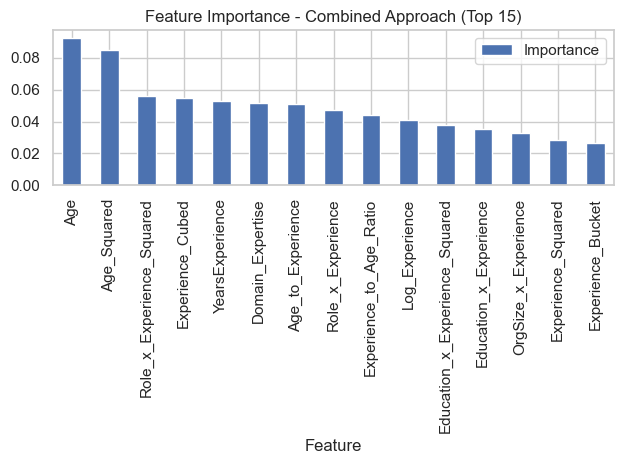

In [77]:
# Display feature importance (top 15 features)
if 'feature_names' in combined_results and hasattr(combined_results['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': combined_results['feature_names'],
        'Importance': combined_results['model'].feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    feature_importance.head(15).plot(kind='bar', x='Feature', y='Importance')
    plt.title('Feature Importance - Combined Approach (Top 15)')
    plt.tight_layout()
    plt.show()

Starting engineer_features
Input DataFrame shape: (1, 5)
Input DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'Age', 'Gender']
Creating experience transformations
Creating experience buckets
Creating age-related features
Creating education level features
Creating job role complexity features
Creating interaction features
Creating gender features
Creating domain expertise features
Engineered DataFrame shape: (1, 23)
Engineered DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'Age', 'Gender', 'Experience_Squared', 'Experience_Cubed', 'Log_Experience', 'Experience_Bucket', 'Age_Squared', 'Age_to_Experience', 'Experience_to_Age_Ratio', 'Career_Stage', 'Education_Level', 'Role_Complexity', 'Education_x_Experience', 'Education_x_Experience_Squared', 'Role_x_Experience', 'Role_x_Experience_Squared', 'Education_x_Role', 'Gender_Numeric', 'Domain_Expertise', 'Is_Senior']
Starting engineer_features
Input DataFrame shape: (1, 5)
Input DataFrame columns: ['YearsExperi

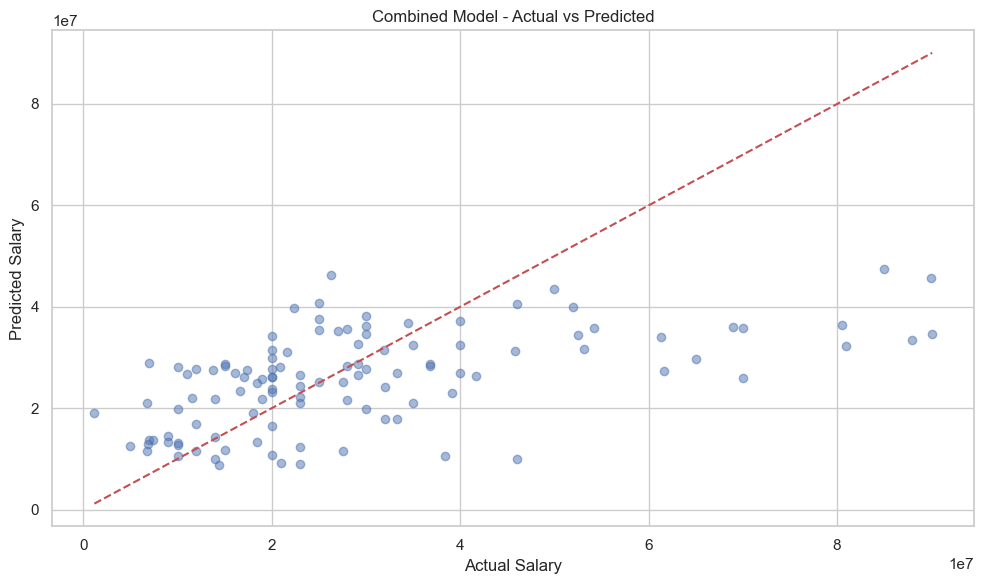

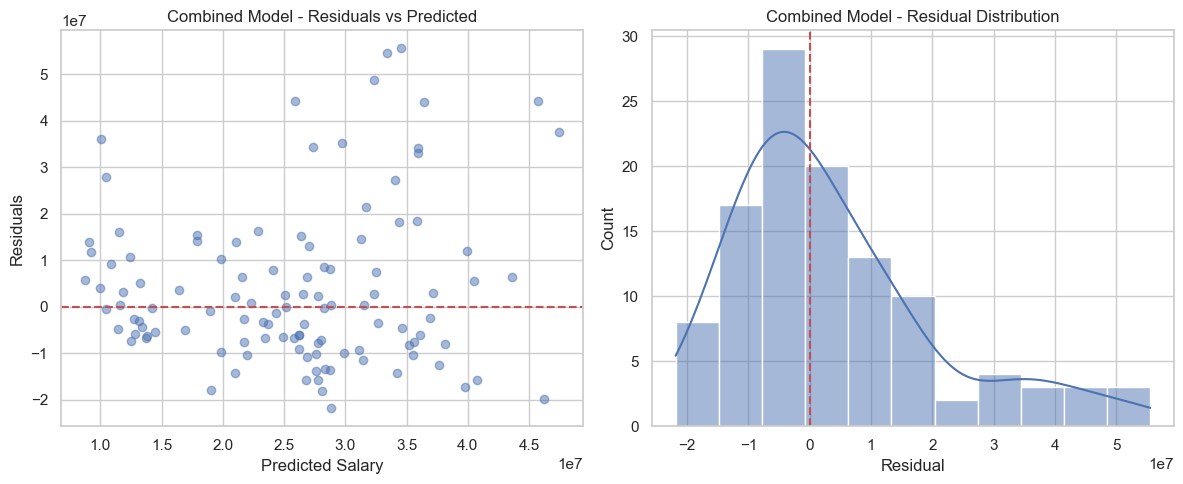

In [78]:
# Evaluate combined model on test data
combined_eval = evaluate_model(combined_model, test_df)

print("Combined Model Test Evaluation:")
for key, value in combined_eval.items():
    if key not in ['predictions', 'actuals']:
        print(f"{key}: {value}")

# Plot actual vs predicted
plot_actual_vs_predicted(combined_eval['actuals'], combined_eval['predictions'], 
                        'Combined Model - Actual vs Predicted')

# Plot residuals
plot_residuals(combined_eval['actuals'], combined_eval['predictions'], 
              'Combined Model')

## 7. Compare All Approaches

Model Performance Comparison:


,Metric,Standard,Feature Engineering,Hyperparameter Tuning,Combined
0,RMSE,17279895.7676,16995479.4322,16963722.9929,17172036.2257
1,R²,0.2557,0.2800,0.2827,0.2650
2,MAE,13233840.3929,12426291.7116,12753255.0179,12292610.0466
3,MAPE (%),68.7020,64.8628,67.9205,60.4314
4,Median AE,10856499.5000,10004701.9095,9733798.5000,8154308.6764
5,Median APE (%),42.4703,39.0853,44.0544,40.1261


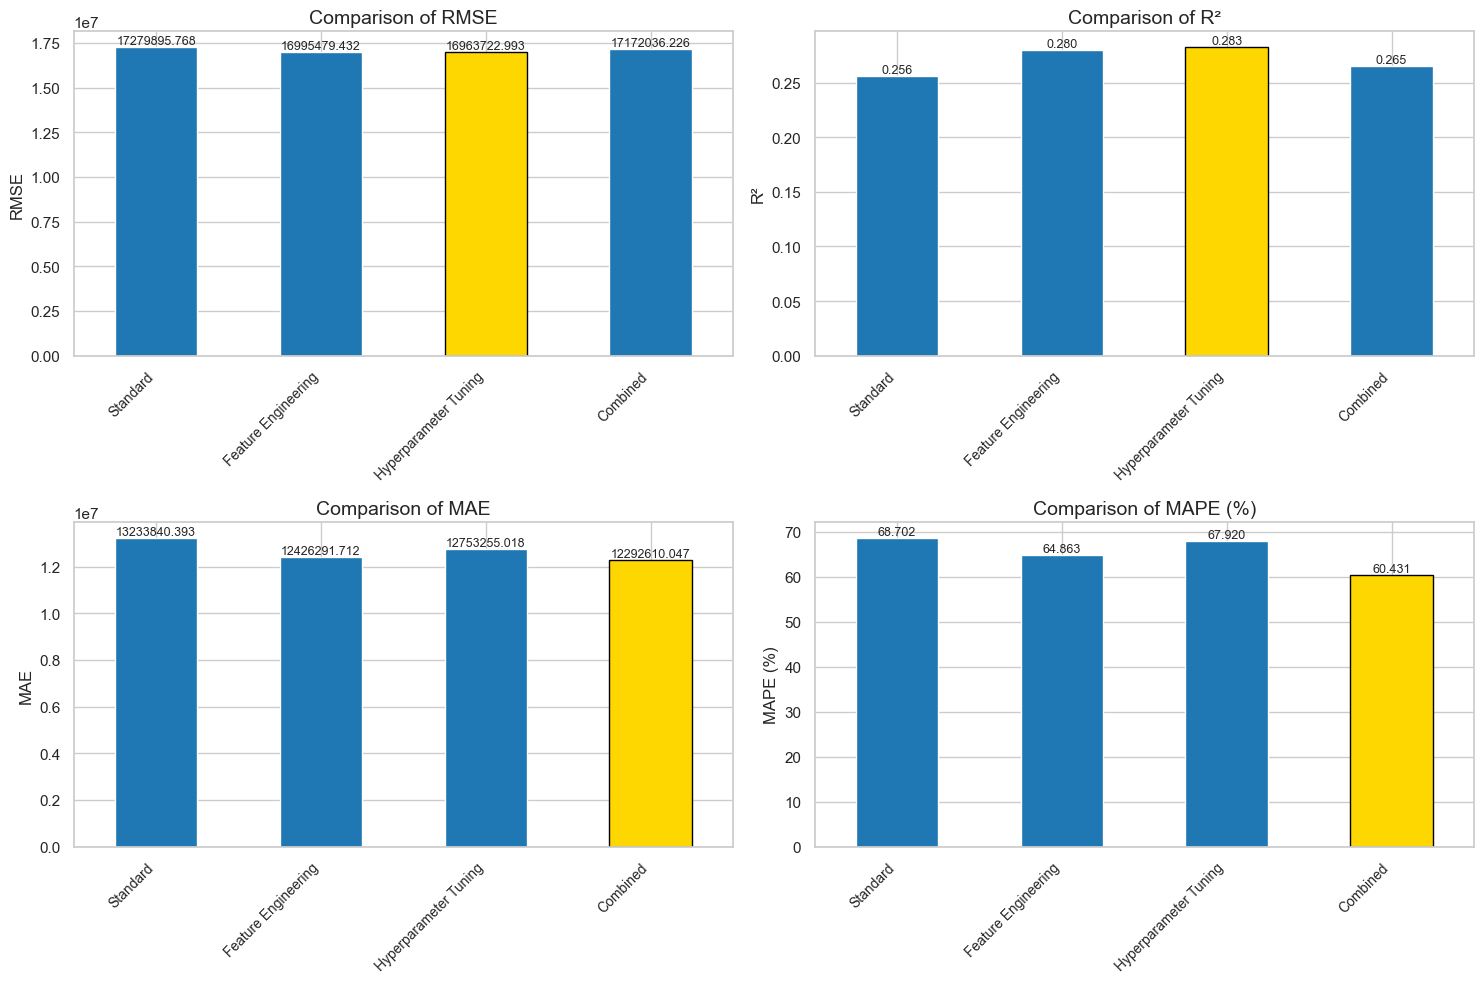

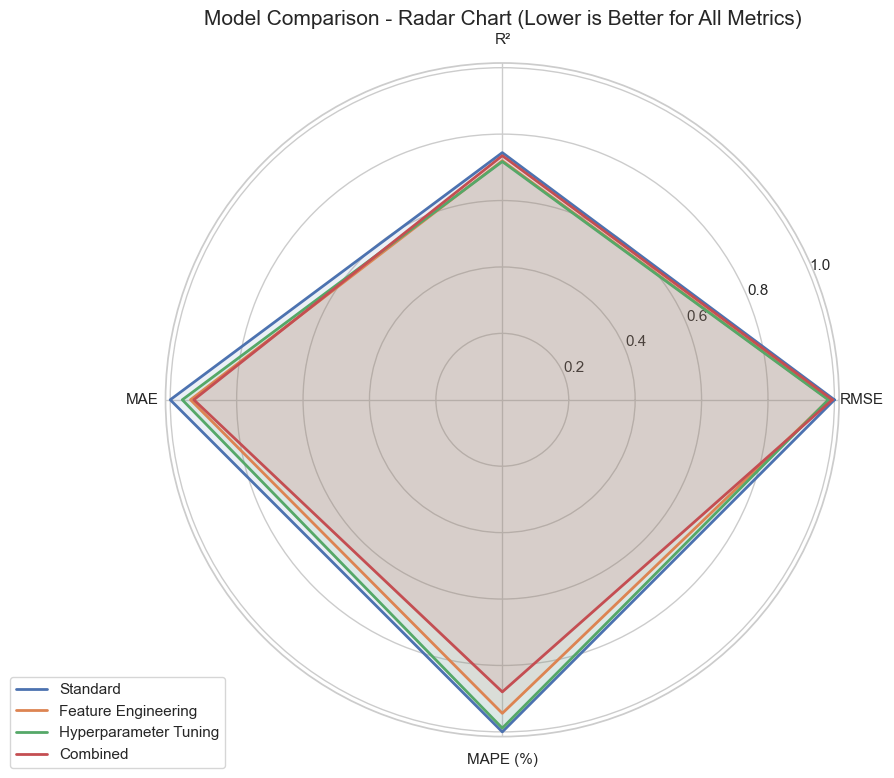

C:\Users\a5155733\AppData\Local\Temp\ipykernel_11200\3136195813.py:190: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\a5155733\MCS\IS\Assignment\RF-VN-Employee-Salary-Predictor\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


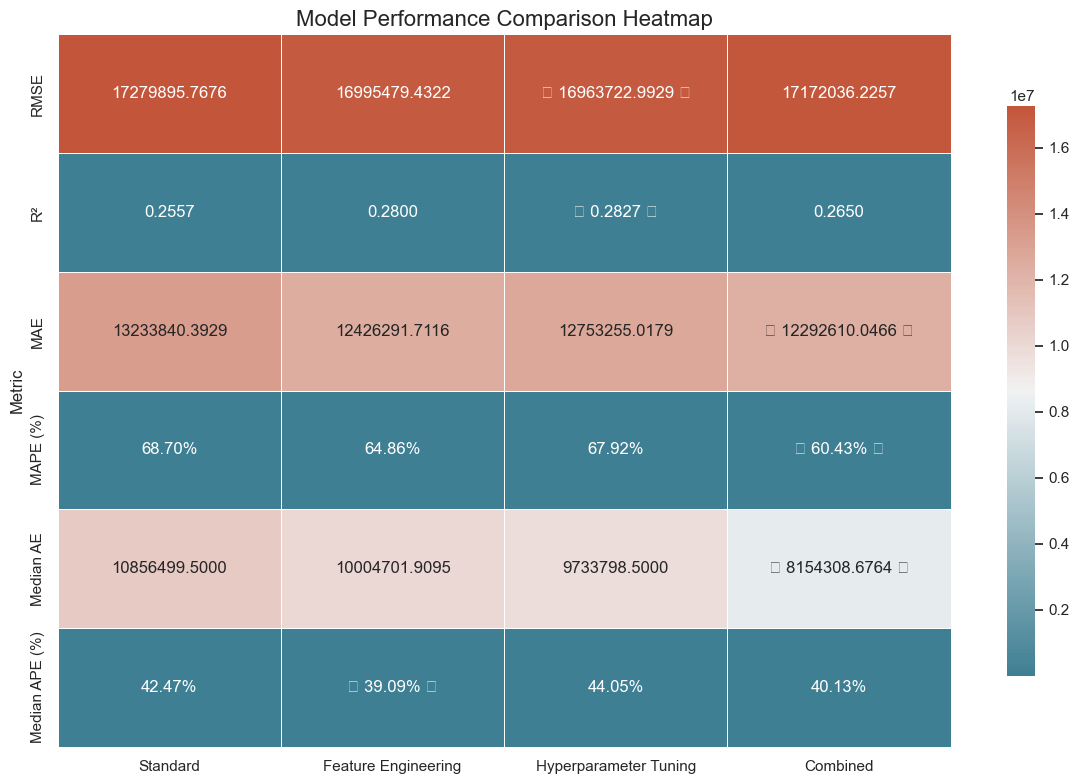


Improvement Percentages Compared to Standard Baseline:


,Metric,Standard,Feature Engineering,Hyperparameter Tuning,Combined
0,RMSE,Baseline,1.65% better,1.83% better,0.62% better
1,R²,Baseline,9.50% better,10.55% better,3.62% better
2,MAE,Baseline,6.10% better,3.63% better,7.11% better
3,MAPE (%),Baseline,5.59% better,1.14% better,12.04% better
4,Median AE,Baseline,7.85% better,10.34% better,24.89% better
5,Median APE (%),Baseline,7.97% better,-3.73% worse,5.52% better



Model Ranking Summary (1 is best):


,Metric,Standard,Feature Engineering,Hyperparameter Tuning,Combined
0,RMSE,4.000000,2.0,1.000000,3.000000
1,R²,4.000000,2.0,1.000000,3.000000
2,MAE,4.000000,2.0,3.000000,1.000000
3,MAPE (%),4.000000,2.0,3.000000,1.000000
4,Median AE,4.000000,3.0,2.000000,1.000000
5,Median APE (%),3.000000,1.0,4.000000,2.000000
0,Average Rank,3.833333,2.0,2.333333,1.833333



🏆 Best Overall Model: Combined with average rank 1.83


In [79]:
## 7. Compare All Approaches

# Collect metrics from all models
metrics_comparison = pd.DataFrame({
    'Metric': ['RMSE', 'R²', 'MAE', 'MAPE (%)', 'Median AE', 'Median APE (%)'],
    'Standard': [standard_eval['rmse'], standard_eval['r2'], 
                standard_eval['mae'], standard_eval['mape'],
                standard_eval['med_ae'], standard_eval['med_ape']],
    'Feature Engineering': [fe_eval['rmse'], fe_eval['r2'], 
                           fe_eval['mae'], fe_eval['mape'],
                           fe_eval['med_ae'], fe_eval['med_ape']],
    'Hyperparameter Tuning': [hp_eval['rmse'], hp_eval['r2'], 
                             hp_eval['mae'], hp_eval['mape'],
                             hp_eval['med_ae'], hp_eval['med_ape']],
    'Combined': [combined_eval['rmse'], combined_eval['r2'], 
                combined_eval['mae'], combined_eval['mape'],
                combined_eval['med_ae'], combined_eval['med_ape']]
})

# Display the metrics comparison table with formatting
def style_metrics_table(df):
    # Create a copy to avoid modifying the original
    styled_df = df.copy()
    
    # Format the metrics with appropriate precision
    for col in styled_df.columns:
        if col != 'Metric':
            styled_df[col] = styled_df[col].apply(lambda x: f"{x:.2f}" if 'MAPE' in styled_df['Metric'].iloc[styled_df.index] or 'APE' in styled_df['Metric'].iloc[styled_df.index] else f"{x:.4f}")
    
    return styled_df

# Display formatted metrics table
print("Model Performance Comparison:")
display(style_metrics_table(metrics_comparison))

# Create bar charts for key metrics comparison
metrics_to_plot = ['RMSE', 'R²', 'MAE', 'MAPE (%)']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Custom colors for each approach
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics_to_plot):
    metric_data = metrics_comparison[metrics_comparison['Metric'] == metric]
    
    # Transpose to get model names as index
    plot_data = metric_data.drop('Metric', axis=1).T
    plot_data.columns = [metric]
    
    # Plot
    ax = axes[i]
    bars = plot_data.plot(kind='bar', ax=ax, legend=False, color=colors)
    ax.set_title(f'Comparison of {metric}', fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    
    # Add value labels on bars
    for j, v in enumerate(plot_data[metric]):
        value = float(v) if isinstance(v, str) else v
        ax.text(j, value, f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Highlight the best model for each metric
    if metric == 'R²':  # Higher is better
        best_idx = plot_data[metric].values.argmax()
        bars.patches[best_idx].set_facecolor('gold')
        bars.patches[best_idx].set_edgecolor('black')
    else:  # Lower is better for RMSE, MAE, MAPE
        best_idx = plot_data[metric].values.argmin()
        bars.patches[best_idx].set_facecolor('gold')
        bars.patches[best_idx].set_edgecolor('black')

plt.tight_layout()
plt.show()

# Create a radar chart for comprehensive comparison
def create_radar_chart(metrics_df):
    # Select metrics for radar chart
    radar_metrics = ['RMSE', 'R²', 'MAE', 'MAPE (%)']
    radar_df = metrics_df[metrics_df['Metric'].isin(radar_metrics)]
    
    # Prepare data
    categories = radar_df['Metric'].tolist()
    models = radar_df.columns[1:].tolist()
    
    # For R², higher is better, so we'll use 1-R² for consistency (lower is better)
    values = []
    for model in models:
        model_values = []
        for i, metric in enumerate(categories):
            val = radar_df.loc[radar_df['Metric'] == metric, model].values[0]
            # Normalize values for better visualization
            if metric == 'R²':
                # For R², higher is better, so we'll invert it (1 - normalized value)
                # First normalize to 0-1 range (higher R² is better)
                normalized = (val - 0) / (1 - 0)  # Assuming R² range is 0 to 1
                # Then invert so lower is better (consistent with other metrics)
                model_values.append(1 - normalized)
            elif metric == 'RMSE':
                # Normalize RMSE to 0-1 range (lower is better)
                max_rmse = radar_df.loc[radar_df['Metric'] == 'RMSE', models].max().max()
                normalized = val / max_rmse
                model_values.append(normalized)
            elif metric == 'MAE':
                # Normalize MAE to 0-1 range (lower is better)
                max_mae = radar_df.loc[radar_df['Metric'] == 'MAE', models].max().max()
                normalized = val / max_mae
                model_values.append(normalized)
            elif metric == 'MAPE (%)':
                # Normalize MAPE to 0-1 range (lower is better)
                max_mape = radar_df.loc[radar_df['Metric'] == 'MAPE (%)', models].max().max()
                normalized = val / max_mape
                model_values.append(normalized)
        values.append(model_values)
    
    # Number of variables
    N = len(categories)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create radar plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # Add lines and points for each model
    for i, model in enumerate(models):
        model_values = values[i]
        model_values += model_values[:1]  # Close the loop
        ax.plot(angles, model_values, linewidth=2, label=model)
        ax.fill(angles, model_values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], categories)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Model Comparison - Radar Chart (Lower is Better for All Metrics)', size=15)
    plt.tight_layout()
    
    return fig

# Create and display radar chart
radar_fig = create_radar_chart(metrics_comparison)
plt.show()

# Create a heatmap for model performance comparison
def create_performance_heatmap(metrics_df):
    # Prepare data for heatmap
    heatmap_data = metrics_df.set_index('Metric')
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create heatmap with custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Create annotations with conditional formatting
    annotations = np.zeros_like(heatmap_data.values, dtype='object')
    
    for i, metric in enumerate(heatmap_data.index):
        row_values = heatmap_data.iloc[i].values
        
        # Determine best value (min or max depending on metric)
        if metric == 'R²':  # Higher is better
            best_value = np.max(row_values)
            is_best = row_values == best_value
        else:  # Lower is better
            best_value = np.min(row_values)
            is_best = row_values == best_value
        
        # Format values and highlight the best
        for j, val in enumerate(row_values):
            if 'MAPE' in metric or 'APE' in metric:
                formatted = f"{val:.2f}%"
            else:
                formatted = f"{val:.4f}"
                
            if is_best[j]:
                annotations[i, j] = f"★ {formatted} ★"
            else:
                annotations[i, j] = formatted
    
    # Create heatmap
    ax = sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap=cmap, 
                    linewidths=0.5, cbar_kws={"shrink": 0.8})
    
    plt.title('Model Performance Comparison Heatmap', fontsize=16)
    plt.tight_layout()
    
    return plt.gcf()

# Create and display heatmap
heatmap_fig = create_performance_heatmap(metrics_comparison)
plt.show()

# Calculate improvement percentages over baseline
def calculate_improvements(metrics_df):
    # Create a copy of the dataframe
    improvements_df = metrics_df.copy()
    
    # Get baseline (Standard) values
    baseline = improvements_df['Standard'].values
    
    # Calculate percentage improvements
    for col in ['Feature Engineering', 'Hyperparameter Tuning', 'Combined']:
        current_values = improvements_df[col].values
        
        # Calculate percentage improvement
        # For R², higher is better, so (new - baseline) / baseline * 100
        # For others, lower is better, so (baseline - new) / baseline * 100
        pct_improvements = []
        
        for i, (metric, base, current) in enumerate(zip(improvements_df['Metric'], baseline, current_values)):
            if metric == 'R²':
                # For R², higher is better
                if base > 0:  # Avoid division by zero or negative
                    pct_improvement = (current - base) / abs(base) * 100
                else:
                    pct_improvement = float('inf') if current > base else 0
            else:
                # For other metrics, lower is better
                pct_improvement = (base - current) / base * 100
                
            pct_improvements.append(pct_improvement)
            
        improvements_df[col] = [f"{val:.2f}% {'better' if val >= 0 else 'worse'}" for val in pct_improvements]
    
    # Set Standard column to baseline
    improvements_df['Standard'] = ['Baseline' for _ in range(len(improvements_df))]
    
    return improvements_df

# Calculate and display improvement percentages
improvements_df = calculate_improvements(metrics_comparison)
print("\nImprovement Percentages Compared to Standard Baseline:")
display(improvements_df)

# Create a summary table with rankings
def create_ranking_summary(metrics_df):
    # Create a copy for rankings
    rankings_df = metrics_df.copy()
    
    # Convert to numeric for ranking
    numeric_df = rankings_df.drop('Metric', axis=1).astype(float)
    
    # Create rankings (1 is best)
    rank_df = pd.DataFrame()
    
    for i, metric in enumerate(rankings_df['Metric']):
        if metric == 'R²':  # Higher is better
            ranks = numeric_df.iloc[i].rank(ascending=False)
        else:  # Lower is better
            ranks = numeric_df.iloc[i].rank(ascending=True)
        
        rank_df = pd.concat([rank_df, ranks.to_frame().T])
    
    # Add metric names
    rank_df.insert(0, 'Metric', rankings_df['Metric'])
    
    # Calculate average rank
    avg_ranks = rank_df.drop('Metric', axis=1).mean()
    avg_row = pd.DataFrame([['Average Rank'] + avg_ranks.tolist()], columns=rank_df.columns)
    
    # Combine
    final_ranks = pd.concat([rank_df, avg_row])
    
    return final_ranks

# Create and display ranking summary
ranking_summary = create_ranking_summary(metrics_comparison)
print("\nModel Ranking Summary (1 is best):")
display(ranking_summary)

# Determine the best overall model
best_model_idx = ranking_summary.iloc[-1, 1:].values.argmin() + 1  # +1 because first column is Metric
best_model = ranking_summary.columns[best_model_idx]

print(f"\n🏆 Best Overall Model: {best_model} with average rank {ranking_summary.iloc[-1, best_model_idx]:.2f}")

In [ ]:
# 1. Gọi hàm train
metrics = fe_model.train_model_with_engineered_features(df, standard_params)

# 2. Lấy y_test và y_pred từ kết quả trả về
y_test = metrics['y_test']
y_pred = metrics['y_pred']

# Tạo bảng so sánh
results = pd.DataFrame({
    'Thực tế': y_test,a
    'Dự đoán': y_pred,
    'Sai số (Triệu)': (y_test - y_pred) / 1_000_000,
    'Sai số (%)': np.abs((y_test - y_pred) / y_test) * 100
})

# Kết hợp với dữ liệu gốc để xem feature (YearsExperience, JobRole...)
# Lưu ý: y_test là 1 phần của df gốc, nên ta dùng index của nó để lấy lại thông tin
X_test_info = df.loc[y_test.index] 
full_analysis = pd.concat([X_test_info, results], axis=1)

Starting model.train_model_with_engineered_features
DataFrame shape: (559, 11)
DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'OrgSize', 'Location', 'Salary', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith', 'Age', 'Gender']
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42}
Cleaning Salary column
Salary column cleaned. Sample values: 0    18400000
1    23000000
2    27600000
3    76666667
4    34500000
Name: Salary, dtype: int64
Filtering out invalid salary values
After filtering, DataFrame shape: (559, 11)
Filling missing values in YearsExperience
Engineering features
Starting engineer_features
Input DataFrame shape: (559, 11)
Input DataFrame columns: ['YearsExperience', 'Education', 'JobRole', 'OrgSize', 'Location', 'Salary', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith', 'Age', 'Gender']
Creating experience transformations
Creating experience buckets
Creating age-related

In [81]:
# In ra Top 5 ca dự đoán sai nhất (Dự đoán thấp hơn thực tế)
print("\n--- TOP 5 CA LƯƠNG CAO MÀ MODEL ĐOÁN THẤP (Under-estimating) ---")
print(full_analysis.sort_values(by='Sai số (Triệu)', ascending=False).head(5)[
    ['YearsExperience', 'JobRole', 'Thực tế', 'Dự đoán', 'Sai số (Triệu)']
])

# In ra Top 5 ca dự đoán sai nhất (Dự đoán cao hơn thực tế)
print("\n--- TOP 5 CA LƯƠNG THẤP MÀ MODEL ĐOÁN CAO (Over-estimating) ---")
print(full_analysis.sort_values(by='Sai số (Triệu)', ascending=True).head(5)[
    ['YearsExperience', 'JobRole', 'Thực tế', 'Dự đoán', 'Sai số (Triệu)']
])


--- TOP 5 CA LƯƠNG CAO MÀ MODEL ĐOÁN THẤP (Under-estimating) ---
     YearsExperience             JobRole   Thực tế       Dự đoán  \
431              9.0    Mobile Developer  90083333  3.147046e+07   
210              7.0      Data Scientist  88000000  3.707722e+07   
137              9.0  Back-end Developer  80500000  3.199470e+07   
234              7.0    Mobile Developer  70000000  2.389455e+07   
261              7.0  Back-end Developer  80960000  3.558769e+07   

     Sai số (Triệu)  
431       58.612872  
210       50.922776  
137       48.505296  
234       46.105448  
261       45.372305  

--- TOP 5 CA LƯƠNG THẤP MÀ MODEL ĐOÁN CAO (Over-estimating) ---
     YearsExperience               JobRole   Thực tế       Dự đoán  \
176             20.0    Back-end Developer  26276250  5.385974e+07   
101             19.0      Mobile Developer  22361111  4.716203e+07   
530              6.0  Full-stack Developer   6750000  2.892991e+07   
554              7.0    Back-end Developer  1000